In [ ]:
import tarfile
def extract(tar_file, path):
    opened_tar = tarfile.open(tar_file)
     
    if tarfile.is_tarfile(tar_file):
        opened_tar.extractall(path)
    else:
        print("The tar file you entered is not a tar file")
        
# extract('../input/stanford-car-dataset-full/car_ims.tar', '/kaggle/working/data/')

In [2]:
!pip install console-progressbar

In [3]:
import numpy as np
import scipy.io as sio 
import os
import shutil
import cv2
import matplotlib.pyplot as plt
import random
from console_progressbar import ProgressBar

# Matching between class number and make name

In [4]:
os.listdir('../input/')

['stanford-cars-dataset', 'mitsub', 'devkitt', 'resnextmod', 'devkit']

In [6]:
def get_make(class_name):
    idx = class_name.find(' ')
    return class_name[:idx]

meta = sio.loadmat('../input/stanford-cars-dataset/cars_annos.mat')
make_list = []
convert = {}

number_to_make = {}
for i, clas in enumerate(meta['class_names'][0]):
    
    make = get_make(clas[0])
    if make not in make_list:
        make_list.append(make)
    convert[i] = make_list.index(make)
    number_to_make[convert[i]] = make

In [7]:
number_to_make[convert[192]]

'Volvo'

In [8]:
def get_labels(path):
    annos = sio.loadmat('../input/devkit/devkit/cars_train_annos.mat')
#     annos = sio.loadmat('../input/stanford-cars-dataset/cars_annos.mat')
    _, total_size = annos["annotations"].shape
    labels = {}
    for i in range(total_size):
        path = annos['annotations'][:,i][0][5][0]
        clas = annos['annotations'][:,i][0][4][0][0]
        labels[path] = convert[clas-1]
    return labels
labels_n= get_labels('cars_train_annos')

In [9]:
print(len(labels_n.keys()))

8144


# Pre-Processing

In [10]:
# for given filenames, labels and boxes function split
# data into validation and training data, cropping bounding boxes
# resizing and saving to a folder, if it's test data we don't have labels and split data
def save_data(fnames, labels, bboxes, data_type='train'):
    if data_type == 'train':
        src_folder = '../input/stanford-cars-dataset/cars_train/cars_train/'
    else:
        src_folder = '../input/stanford-cars-dataset/cars_test/cars_test'
    num_samples = len(fnames)
    
    if data_type == 'train':
        perm = np.random.permutation(num_samples)

        train_split = 0.8
        num_train = int(round(num_samples * train_split))

    pb = ProgressBar(total=100, prefix='Save train data', suffix='', decimals=3, length=50, fill='=')

    for i in range(num_samples):
        fname = fnames[i]
        if data_type == 'train':
            label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]

        src_path = os.path.join(src_folder, fname)
        src_image = cv2.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        # print("{} -> {}".format(fname, label))
        pb.print_progress_bar((i + 1) * 100 / num_samples)
        dst_path = os.path.join('/kaggle/working/data/test', fname)
        if data_type == 'train':
            if i < num_train:
                dst_folder = '/kaggle/working/data/train/'
            else:
                dst_folder = '/kaggle/working/data/valid/'

            dst_path = os.path.join(dst_folder, label)
            if not os.path.exists(dst_path):
                os.makedirs(dst_path)
            dst_path = os.path.join(dst_path, fname)

        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv2.resize(src=crop_image, dsize=(224, 224))
        cv2.imwrite(dst_path, dst_img)        

In [11]:
# parsing labels: class indexes, bounding boxes, file names
def process_data(data_type = 'train'):
    print("Processing train data...")
    if data_type == 'train':
        cars_annos = sio.loadmat('../input/devkit/devkit/cars_train_annos.mat')
    else:
        cars_annos = sio.loadmat('../input/stanford-cars-dataset/car_devkit/devkit/cars_test_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    class_ids = []
    bboxes = []
    labels = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        
        if data_type == 'train':
            class_id = annotation[0][4][0][0]
            fname = annotation[0][5][0]
            labels.append('%02d' % labels_n[fname])
            class_ids.append(labels_n[fname])
            
        else:
            fname = annotation[0][4][0]
        
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        fnames.append(fname)
        
    if data_type == 'train':
        labels_count = np.unique(class_ids).shape[0]
        print(np.unique(class_ids))
        print('The number of different cars is %d' % labels_count)
    else:
        print('Test data processing')
    save_data(fnames, labels, bboxes, data_type)

In [12]:
def make_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [13]:
new_dirs = ['/kaggle/working/data/train', '/kaggle/working/data/valid', '/kaggle/working/data/test']

for new_dir in new_dirs:
    make_folder(new_dir)

In [14]:
process_data('train')

Processing train data...
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48]
The number of different cars is 49
Save train data |==================================================| 100.000% 


In [15]:
process_data('test')

Processing train data...
Test data processing
Save train data |==================================================| 100.000% 


In [ ]:
def del_dirs(dirs_list):
    for dirr in dirs_list:
        shutil.rmtree(dirr)
# del_dirs(new_dirs)

# Creating data transformations, data loaders

In [16]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [17]:
bs = 64

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=bs,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

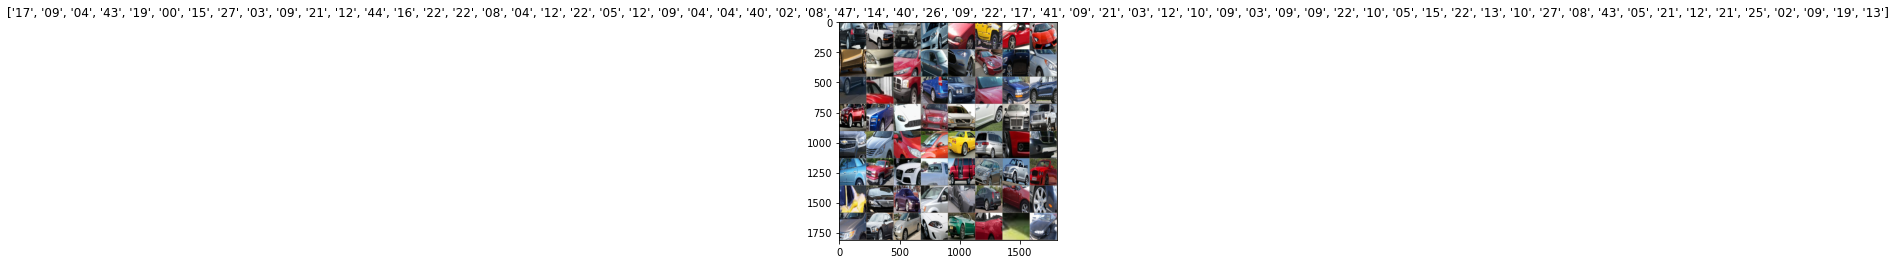

In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

# Function for model training

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        # clip
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [31]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                print(preds[j])
                ax.set_title('predicted: {}'.format(make_list[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [21]:
# using focal loss function for better result
import torch.nn.functional as F
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

In [22]:
# using resnext pretrained model
model_conv = torchvision.models.resnext101_32x8d(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
# fine tuning last layer of resnext pretrained model
model_conv.fc = nn.Sequential(
                                nn.Linear(num_ftrs, 512),
                                nn.ReLU(),
                                nn.BatchNorm1d(512),
                                nn.Linear(512, 49)
                                )
model_conv = model_conv.to(device)
criterion = FocalLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters())#, lr=0.0, lr_decay=0.96)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/checkpoints/resnext101_32x8d-8ba56ff5.pth


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=100)

In [ ]:
torch.save(model_conv, '/kaggle/working/data/modresn66')

In [23]:
model = torch.load('../input/resnextmod/modresn66')

In [25]:
for name, param in model.named_parameters():
    if name in ['fc.3.weight','fc.3.bias']:
        param.requires_grad = False

model = model.to(device)
criterion = FocalLoss()
optimizer_conv = optim.Adam(model.fc.parameters(), lr=0.00003, weight_decay = 1e-9)
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer=optimizer_conv, gamma=0.96)


In [26]:
model = train_model(model, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.6061 Acc: 0.7492
valid Loss: 0.8332 Acc: 0.6863
Epoch 1/49
----------
train Loss: 0.5729 Acc: 0.7552
valid Loss: 0.8188 Acc: 0.6906
Epoch 2/49
----------
train Loss: 0.5642 Acc: 0.7596
valid Loss: 0.8209 Acc: 0.6832
Epoch 3/49
----------
train Loss: 0.5720 Acc: 0.7589
valid Loss: 0.8107 Acc: 0.6882
Epoch 4/49
----------
train Loss: 0.5730 Acc: 0.7564
valid Loss: 0.8130 Acc: 0.6863
Epoch 5/49
----------
train Loss: 0.5808 Acc: 0.7538
valid Loss: 0.8008 Acc: 0.6906
Epoch 6/49
----------
train Loss: 0.5548 Acc: 0.7619
valid Loss: 0.8054 Acc: 0.6875
Epoch 7/49
----------
train Loss: 0.5758 Acc: 0.7581
valid Loss: 0.8004 Acc: 0.6894
Epoch 8/49
----------
train Loss: 0.5345 Acc: 0.7672
valid Loss: 0.7951 Acc: 0.6869
Epoch 9/49
----------
train Loss: 0.5422 Acc: 0.7716
valid Loss: 0.7998 Acc: 0.6888
Epoch 10/49
----------
train Loss: 0.5539 Acc: 0.7556
valid Loss: 0.7938 Acc: 0.6906
Epoch 11/49
----------
train Loss: 0.5632 Acc: 0.7691
valid Loss: 0.8073 Ac

tensor(31, device='cuda:0')


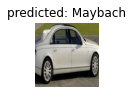

tensor(10, device='cuda:0')


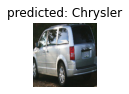

tensor(12, device='cuda:0')


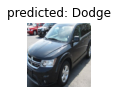

tensor(22, device='cuda:0')


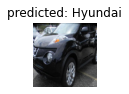

tensor(6, device='cuda:0')


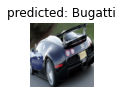

tensor(23, device='cuda:0')


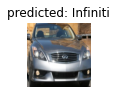

In [32]:
visualize_model(model)

plt.ioff()
plt.show()

In [33]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [60]:
torch.save(model, '/kaggle/working/data/final_make_70')

In [34]:
from torch.autograd import Variable
def image_loader(img):
    image = data_transforms['valid'](img).float()
    plt.imshow(img)
    image = torch.Tensor(image)
    image = image.unsqueeze(0)
    return image.cuda()  #assumes that you're using GPU

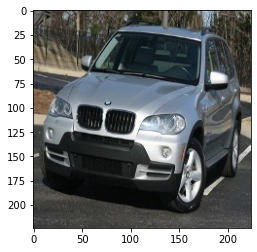

In [35]:
from PIL import Image, ImageFile
num_samples,all_preds = 8041,[]
out = open('result.txt', 'a')
for i in range(num_samples):
    filename = os.path.join('./data/test', '%05d.jpg' % (i + 1))
    bgr_img = cv2.imread(filename)
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    im_pil = Image.fromarray(rgb_img)
    
    im_pill = image_loader(im_pil)
    preds = model(im_pill)
    
    class_id = preds.max(1)[1]
    all_preds.append(class_id)
    out.write('{}\n'.format(str(class_id + 1)))
    
out.close()


In [36]:
labels = sio.loadmat('../input/devkitt/cars_test_annos_withlabels.mat')
a = []
for lab in labels['annotations']['class'][0]:
#     print(lab)
    a.append(convert[lab[0][0]-1])
actual_preds = np.array(a,dtype=np.int);
actual_preds = actual_preds.squeeze()
all_preds = np.array(all_preds)

In [38]:
from sklearn.metrics import classification_report

In [41]:
print('accuracy = ',(all_preds==actual_preds).sum()/len(actual_preds))

accuracy =  0.680636736724288


In [58]:
from sklearn.metrics import f1_score
print("f1 score {}".format(f1_score(actual_preds.tolist(), all_preds.tolist(), average='macro')))

f1 score 0.6892359828413914


In [ ]:
print(classification_report(actual_preds.tolist(), all_preds.tolist(), target_names=make_list, labels=make_list, zero_division=1))

# Test

### Preprocess for input image

In [63]:
final_model = torch.load('./data/final_make_70', map_location='cpu')

In [69]:
import ssl
import base64
from PIL import Image, ImageFile
import http.client as httplib

headers = {"Content-type": "application/json",
           "X-Access-Token": "yrkuYbYWugkjcM3tfpO4ffCGHHOYgaJehWOD"}

def plotting(path, x1, y1, x2, y2):
    src_image = cv2.imread(path)
    crop_image = src_image[y1:y2, x1:x2]    
    plt.imshow(crop_image[:,:,::-1])

def get_box(path):
    
    image_data = base64.b64encode(open(path, 'rb').read()).decode()
    params = json.dumps({"image": image_data})
    
    conn = httplib.HTTPSConnection("dev.sighthoundapi.com", 
        context=ssl.SSLContext(ssl.PROTOCOL_TLSv1_2))
    
    conn.request("POST", "/v1/recognition?objectType=vehicle", params, headers)
    response = conn.getresponse()
    result = response.read()
    json_obj = json.loads(result)

    if 'reasonCode' in json_obj and json_obj['reasonCode'] == 50202:
        print(json_obj)
        return 'TL'
    if not json_obj or 'objects' not in json_obj or len(json_obj['objects']) < 1:
        return False
    
    annot = json_obj['objects'][0]['vehicleAnnotation']
    vertices = annot['bounding']['vertices']
    xy1 = vertices[0]
    xy3 = vertices[2]
    return xy1['x'], xy1['y'], xy3['x'], xy3['y']

def crop_car(src_path, x1, y1, x2, y2):
    src_image = cv2.imread(src_path)
    if src_image is None:
        return
    crop_image = src_image[y1:y2, x1:x2]
    dst_img = cv2.resize(src=crop_image, dsize=(224, 224))
    img = Image.fromarray(dst_img)
    image = data_transforms['valid'](img).float()
    image = torch.Tensor(image)
    return image.unsqueeze(0)
#     return image.unsqueeze(0).cuda() # if cuda

In [70]:
def predict_make(src):
    resp = get_box(src)
    if not resp:
        return "error"
    plotting(src, *resp)
    image = crop_car(src, *resp)
    preds = final_model(image)
    return make_list[int(preds.max(1)[1][0])]

'Ford'

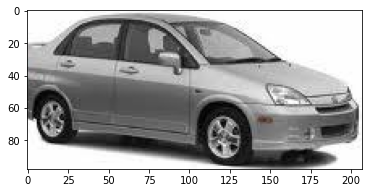

In [71]:
import json
predict_make('../input/stanford-cars-dataset/cars_test/cars_test/00001.jpg')